In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

df = pd.read_csv('data_cleaned.csv')
df_orders = pd.read_csv('orders_aggregated.csv')

date_cols = ['order_purchase_timestamp', 'order_delivered_customer_date', 
             'order_estimated_delivery_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])
    if col in df_orders.columns:
        df_orders[col] = pd.to_datetime(df_orders[col])

df['order_month'] = pd.to_datetime(df['order_month'].astype(str))
df_orders['order_month'] = pd.to_datetime(df_orders['order_month'].astype(str))

print(f"Dataset carregado: {len(df):,} itens, {len(df_orders):,} pedidos")
print()

Dataset carregado: 112,640 itens, 98,658 pedidos



KPIs PRINCIPAIS

In [3]:
# 1.1. Receita e Componentes

total_revenue = df_orders['total'].sum()
total_subtotal = df_orders['subtotal'].sum()
total_freight = df_orders['freight'].sum()

print(f"Receita Total: R$ {total_revenue:,.2f}")
print(f"  └─ Subtotal (Produtos): R$ {total_subtotal:,.2f} ({total_subtotal/total_revenue*100:.2f}%)")
print(f"  └─ Frete: R$ {total_freight:,.2f} ({total_freight/total_revenue*100:.2f}%)")
print()

Receita Total: R$ 15,841,171.67
  └─ Subtotal (Produtos): R$ 13,589,426.41 (85.79%)
  └─ Frete: R$ 2,251,745.26 (14.21%)



In [4]:
#TICKET MÉDIO
avg_ticket = df_orders['total'].mean()
median_ticket = df_orders['total'].median()

print(f"Ticket Médio: R$ {avg_ticket:.2f}")
print(f"Ticket Mediano: R$ {median_ticket:.2f}")
print()

Ticket Médio: R$ 160.57
Ticket Mediano: R$ 105.29



In [5]:
avg_freight = df_orders['freight'].mean()
freight_share = (total_freight / total_revenue) * 100

print(f"Frete Médio: R$ {avg_freight:.2f}")
print(f"Take-rate de Frete: {freight_share:.2f}%")
print(f"  (Proporção do frete na receita total)")
print()


Frete Médio: R$ 22.82
Take-rate de Frete: 14.21%
  (Proporção do frete na receita total)



In [6]:
# Calcular desconto implícito (diferença entre payment_value e total)
df_orders['discount_amount'] = df_orders['payment_value'] - df_orders['total']
df_orders['discount_pct'] = (df_orders['discount_amount'] / df_orders['total'] * 100).clip(-100, 100)

avg_discount_pct = df_orders['discount_pct'].mean()
median_discount_pct = df_orders['discount_pct'].median()

print(f"Desconto Médio: {avg_discount_pct:.2f}%")
print(f"Desconto Mediano: {median_discount_pct:.2f}%")
print(f"⚠ Nota: Valores negativos indicam pagamento > total (possível taxa de serviço)")
print()

Desconto Médio: 0.02%
Desconto Mediano: 0.00%
⚠ Nota: Valores negativos indicam pagamento > total (possível taxa de serviço)



In [7]:
# 1.5. Prazo de Entrega
avg_delivery_time = df_orders['delivery_lead_time'].mean()
median_delivery_time = df_orders['delivery_lead_time'].median()

print(f"Prazo Médio de Entrega: {avg_delivery_time:.2f} dias")
print(f"Prazo Mediano de Entrega: {median_delivery_time:.2f} dias")
print()

Prazo Médio de Entrega: 12.09 dias
Prazo Mediano de Entrega: 10.00 dias



In [8]:
delivered = df_orders[df_orders['order_status'] == 'delivered']
late_orders = delivered[delivered['is_late'] == 1]

late_rate = (len(late_orders) / len(delivered)) * 100
avg_delay = late_orders['delivery_delay_days'].mean()

print(f"Taxa de Atraso: {late_rate:.2f}%")
print(f"Atraso Médio (quando atrasado): {avg_delay:.2f} dias")
print()

Taxa de Atraso: 6.77%
Atraso Médio (quando atrasado): 10.62 dias



In [9]:
# 1.7. Conversão de Pagamento

status_counts = df_orders['order_status'].value_counts()
total_orders = len(df_orders)

confirmed_rate = (status_counts.get('delivered', 0) / total_orders) * 100
canceled_rate = (status_counts.get('canceled', 0) / total_orders) * 100

print(f"Taxa de Confirmação (Delivered): {confirmed_rate:.2f}%")
print(f"Taxa de Cancelamento: {canceled_rate:.2f}%")
print()


# Conversão por tipo de pagamento
print("Conversão por Tipo de Pagamento:")
payment_conversion = df_orders.groupby('payment_type').agg({
    'order_id': 'count',
    'is_confirmed': 'sum',
    'is_canceled': 'sum'
}).reset_index()
payment_conversion['confirmed_rate'] = (payment_conversion['is_confirmed'] / 
                                         payment_conversion['order_id'] * 100)
payment_conversion['canceled_rate'] = (payment_conversion['is_canceled'] / 
                                        payment_conversion['order_id'] * 100)

print(payment_conversion[['payment_type', 'order_id', 'confirmed_rate', 'canceled_rate']].to_string(index=False))
print()


Taxa de Confirmação (Delivered): 97.79%
Taxa de Cancelamento: 0.47%

Conversão por Tipo de Pagamento:
payment_type  order_id  confirmed_rate  canceled_rate
      boleto     19614       97.843377       0.402774
 credit_card     75615       97.786154       0.487998
  debit_card      1520       97.631579       0.394737
     voucher      1908       97.536688       0.366876



ANÁLISE DE SAZONALIDADE

In [10]:
# 2.1. Sazonalidade Mensal

monthly_kpis = df_orders.groupby('order_month').agg({
    'order_id': 'count',
    'total': 'sum',
    'freight': 'mean',
    'delivery_lead_time': 'mean'
}).reset_index()
monthly_kpis.columns = ['month', 'n_orders', 'revenue', 'avg_freight', 'avg_delivery_time']

max_month = monthly_kpis.loc[monthly_kpis['n_orders'].idxmax()]
min_month = monthly_kpis.loc[monthly_kpis['n_orders'].idxmin()]

print(f"Mês com MAIOR volume: {max_month['month'].strftime('%Y-%m')}")
print(f"  └─ {max_month['n_orders']:.0f} pedidos, R$ {max_month['revenue']:,.2f}")
print()
print(f"Mês com MENOR volume: {min_month['month'].strftime('%Y-%m')}")
print(f"  └─ {min_month['n_orders']:.0f} pedidos, R$ {min_month['revenue']:,.2f}")
print()

# 2.2. Sazonalidade por Estado
print("2.2. TOP 5 ESTADOS POR RECEITA")

state_kpis = df_orders.groupby('customer_state').agg({
    'order_id': 'count',
    'total': 'sum'
}).reset_index()
state_kpis.columns = ['state', 'n_orders', 'revenue']
state_kpis = state_kpis.sort_values('revenue', ascending=False).head(5)

print(state_kpis.to_string(index=False))
print()

# 2.3. Sazonalidade por Região
print("2.3. ANÁLISE POR REGIÃO")

region_kpis = df_orders.groupby('customer_region').agg({
    'order_id': 'count',
    'total': ['sum', 'mean'],
    'freight': 'mean',
    'delivery_lead_time': 'mean',
    'is_late': 'mean'
}).reset_index()
region_kpis.columns = ['region', 'n_orders', 'revenue', 'avg_ticket', 
                        'avg_freight', 'avg_delivery_time', 'late_rate']
region_kpis['late_rate'] = region_kpis['late_rate'] * 100
region_kpis = region_kpis.sort_values('revenue', ascending=False)

print(region_kpis.to_string(index=False))
print()

Mês com MAIOR volume: 2017-11
  └─ 7451 pedidos, R$ 1,179,143.77

Mês com MENOR volume: 2016-12
  └─ 1 pedidos, R$ 19.62

2.2. TOP 5 ESTADOS POR RECEITA
state  n_orders    revenue
   SP     41371 5920134.69
   RJ     12761 2129368.40
   MG     11542 1855907.68
   RS      5431  885556.01
   PR      4998  800935.44

2.3. ANÁLISE POR REGIÃO
      region  n_orders     revenue  avg_ticket  avg_freight  avg_delivery_time  late_rate
     Sudeste     67699 10230212.68  151.113202    19.864208          10.289269   5.980886
         Sul     14041  2296705.05  163.571330    24.429444          13.558636   5.804430
    Nordeste      9336  1880799.54  201.456677    35.915359          19.536046  12.317909
Centro-Oeste      5744  1023062.00  178.109680    26.566842          14.563656   6.389276
       Norte      1838   410392.40  223.282046    41.370343          22.144209   8.378672



PERFORMANCE LOGÍSTICA

In [11]:
# Análise por região com foco em logística

logistics_by_region = df_orders[df_orders['order_status'] == 'delivered'].groupby('customer_region').agg({
    'delivery_lead_time': ['mean', 'median', 'std'],
    'is_late': 'mean',
    'delivery_delay_days': lambda x: x[x > 0].mean() if (x > 0).any() else 0
}).reset_index()

logistics_by_region.columns = ['region', 'avg_lead_time', 'median_lead_time', 
                                 'std_lead_time', 'late_rate', 'avg_delay_when_late']
logistics_by_region['late_rate'] = logistics_by_region['late_rate'] * 100
logistics_by_region = logistics_by_region.sort_values('late_rate', ascending=False)

print(logistics_by_region.to_string(index=False))
print()

print("INSIGHTS LOGÍSTICOS:")
worst_region = logistics_by_region.iloc[0]
print(f"  • Região com PIOR performance: {worst_region['region']}")
print(f"    - Taxa de atraso: {worst_region['late_rate']:.2f}%")
print(f"    - Prazo médio: {worst_region['avg_lead_time']:.2f} dias")
print()

best_region = logistics_by_region.iloc[-1]
print(f"  • Região com MELHOR performance: {best_region['region']}")
print(f"    - Taxa de atraso: {best_region['late_rate']:.2f}%")
print(f"    - Prazo médio: {best_region['avg_lead_time']:.2f} dias")
print()

      region  avg_lead_time  median_lead_time  std_lead_time  late_rate  avg_delay_when_late
    Nordeste      19.536046              17.0      12.254414  12.715613            12.426087
       Norte      22.144209              20.0      13.100504   8.574610            13.493506
Centro-Oeste      14.563656              13.0       8.393141   6.525605             9.430518
     Sudeste      10.288701               8.0       8.509714   6.114804            10.415020
         Sul      13.557446              12.0       8.437792   5.899812             9.083436

INSIGHTS LOGÍSTICOS:
  • Região com PIOR performance: Nordeste
    - Taxa de atraso: 12.72%
    - Prazo médio: 19.54 dias

  • Região com MELHOR performance: Sul
    - Taxa de atraso: 5.90%
    - Prazo médio: 13.56 dias



MIX DE PRODUTOS

In [12]:
print("4.1. TOP 10 CATEGORIAS POR RECEITA")
print("-"*80)

category_kpis = df.groupby('product_category_name_english').agg({
    'order_id': 'count',
    'total': 'sum',
    'price': 'mean'
}).reset_index()
category_kpis.columns = ['category', 'n_items', 'revenue', 'avg_price']
category_kpis = category_kpis.sort_values('revenue', ascending=False).head(10)

print(category_kpis.to_string(index=False))
print()

4.1. TOP 10 CATEGORIAS POR RECEITA
--------------------------------------------------------------------------------
             category  n_items    revenue  avg_price
        health_beauty     9670 1441248.07 130.163531
        watches_gifts     5991 1305541.61 201.135984
       bed_bath_table    11115 1241681.72  93.296327
       sports_leisure     8641 1156656.48 114.344285
computers_accessories     7825 1059210.78 116.538610
      furniture_decor     8334  902511.79  87.564494
           housewares     6963  778218.31  90.776786
           cool_stuff     3795  719239.72 167.384967
                 auto     4234  685338.36 139.982312
         garden_tools     4347  584219.21 111.630196



INSIGHTS ACIONÁVEIS

In [13]:
insights = []

# Insight 1: Ticket Médio por Forma de Pagamento
credit_ticket = df_orders[df_orders['payment_type'] == 'credit_card']['total'].mean()
boleto_ticket = df_orders[df_orders['payment_type'] == 'boleto']['total'].mean()
diff_pct = ((credit_ticket - boleto_ticket) / boleto_ticket) * 100

insights.append({
    'id': 1,
    'categoria': 'Receita',
    'insight': f'Clientes que pagam com cartão de crédito têm ticket médio {diff_pct:.1f}% maior (R$ {credit_ticket:.2f}) que boleto (R$ {boleto_ticket:.2f})',
    'acao': 'Incentivar pagamento com cartão através de cashback ou parcelamento sem juros'
})

# Insight 2: Taxa de Atraso Regional
norte_late = logistics_by_region[logistics_by_region['region'] == 'Norte']['late_rate'].values[0]
sudeste_late = logistics_by_region[logistics_by_region['region'] == 'Sudeste']['late_rate'].values[0]

insights.append({
    'id': 2,
    'categoria': 'Logística',
    'insight': f'Região Norte tem taxa de atraso {norte_late:.1f}% vs {sudeste_late:.1f}% no Sudeste - diferença de {norte_late-sudeste_late:.1f} pontos percentuais',
    'acao': 'Revisar parceiros logísticos no Norte e ajustar prazos estimados para reduzir insatisfação'
})

# Insight 3: Frete como % da Receita
insights.append({
    'id': 3,
    'categoria': 'Frete',
    'insight': f'Frete representa {freight_share:.2f}% da receita total - valor significativo que impacta margem',
    'acao': 'Negociar melhores tarifas com transportadoras e considerar frete grátis acima de valor mínimo'
})

# Insight 4: Sazonalidade
growth = ((monthly_kpis['n_orders'].iloc[-3:].mean() - 
           monthly_kpis['n_orders'].iloc[:3].mean()) / 
          monthly_kpis['n_orders'].iloc[:3].mean() * 100)

insights.append({
    'id': 4,
    'categoria': 'Sazonalidade',
    'insight': f'Crescimento de {growth:.1f}% no volume de pedidos comparando início e fim do período',
    'acao': 'Preparar estoque e capacidade logística para períodos de pico (Black Friday, Natal)'
})

# Insight 5: Taxa de Cancelamento
insights.append({
    'id': 5,
    'categoria': 'Conversão',
    'insight': f'Taxa de cancelamento de {canceled_rate:.2f}% é baixa, mas representa {status_counts.get("canceled", 0)} pedidos perdidos',
    'acao': 'Investigar motivos de cancelamento e implementar recuperação de carrinho abandonado'
})

# Imprimir insights
for insight in insights:
    print(f"INSIGHT #{insight['id']}: {insight['categoria'].upper()}")
    print(f"  📊 {insight['insight']}")
    print(f"  🎯 Ação: {insight['acao']}")
    print()

INSIGHT #1: RECEITA
  📊 Clientes que pagam com cartão de crédito têm ticket médio 14.7% maior (R$ 166.20) que boleto (R$ 144.91)
  🎯 Ação: Incentivar pagamento com cartão através de cashback ou parcelamento sem juros

INSIGHT #2: LOGÍSTICA
  📊 Região Norte tem taxa de atraso 8.6% vs 6.1% no Sudeste - diferença de 2.5 pontos percentuais
  🎯 Ação: Revisar parceiros logísticos no Norte e ajustar prazos estimados para reduzir insatisfação

INSIGHT #3: FRETE
  📊 Frete representa 14.21% da receita total - valor significativo que impacta margem
  🎯 Ação: Negociar melhores tarifas com transportadoras e considerar frete grátis acima de valor mínimo

INSIGHT #4: SAZONALIDADE
  📊 Crescimento de 4058.8% no volume de pedidos comparando início e fim do período
  🎯 Ação: Preparar estoque e capacidade logística para períodos de pico (Black Friday, Natal)

INSIGHT #5: CONVERSÃO
  📊 Taxa de cancelamento de 0.47% é baixa, mas representa 461 pedidos perdidos
  🎯 Ação: Investigar motivos de cancelamento e 

6. GERANDO DASHBOARD DE KPIs
--------------------------------------------------------------------------------


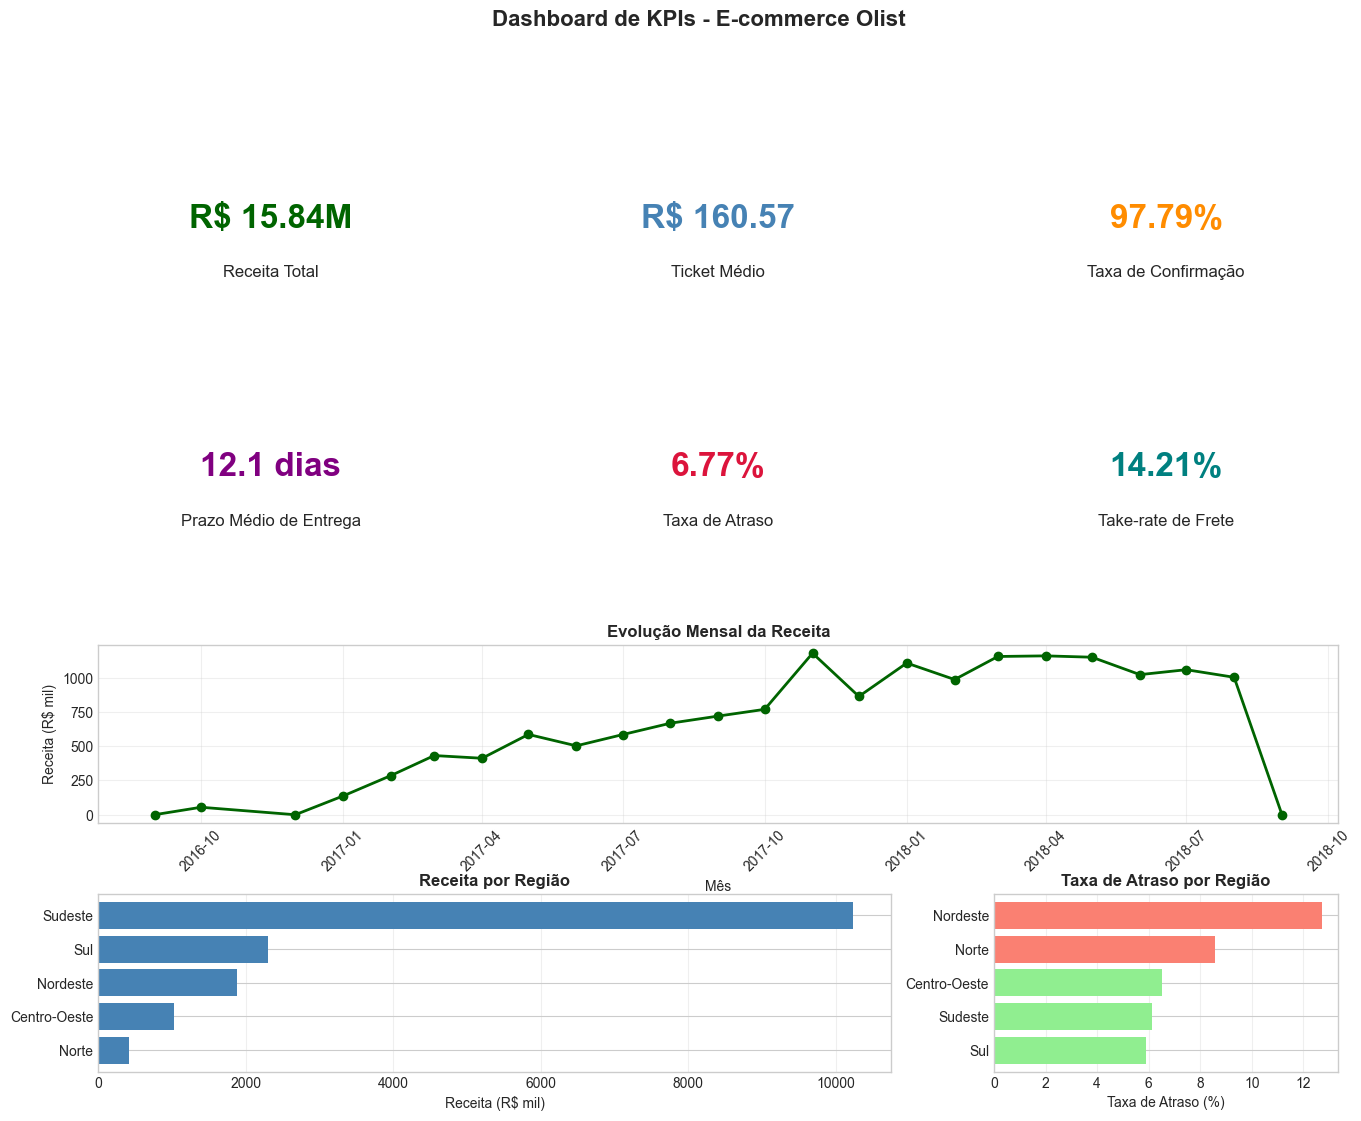

✓ Salvo: kpis_dashboard.png


In [14]:

print("6. GERANDO DASHBOARD DE KPIs")
print("-"*80)

# Criar visualização consolidada de KPIs
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

# KPI 1: Receita Total
ax1 = fig.add_subplot(gs[0, 0])
ax1.text(0.5, 0.6, f'R$ {total_revenue/1e6:.2f}M', 
         ha='center', va='center', fontsize=24, fontweight='bold', color='darkgreen')
ax1.text(0.5, 0.3, 'Receita Total', ha='center', va='center', fontsize=12)
ax1.axis('off')
ax1.set_facecolor('#e8f5e9')

# KPI 2: Ticket Médio
ax2 = fig.add_subplot(gs[0, 1])
ax2.text(0.5, 0.6, f'R$ {avg_ticket:.2f}', 
         ha='center', va='center', fontsize=24, fontweight='bold', color='steelblue')
ax2.text(0.5, 0.3, 'Ticket Médio', ha='center', va='center', fontsize=12)
ax2.axis('off')
ax2.set_facecolor('#e3f2fd')

# KPI 3: Taxa de Confirmação
ax3 = fig.add_subplot(gs[0, 2])
ax3.text(0.5, 0.6, f'{confirmed_rate:.2f}%', 
         ha='center', va='center', fontsize=24, fontweight='bold', color='darkorange')
ax3.text(0.5, 0.3, 'Taxa de Confirmação', ha='center', va='center', fontsize=12)
ax3.axis('off')
ax3.set_facecolor('#fff3e0')

# KPI 4: Prazo Médio
ax4 = fig.add_subplot(gs[1, 0])
ax4.text(0.5, 0.6, f'{avg_delivery_time:.1f} dias', 
         ha='center', va='center', fontsize=24, fontweight='bold', color='purple')
ax4.text(0.5, 0.3, 'Prazo Médio de Entrega', ha='center', va='center', fontsize=12)
ax4.axis('off')
ax4.set_facecolor('#f3e5f5')

# KPI 5: Taxa de Atraso
ax5 = fig.add_subplot(gs[1, 1])
ax5.text(0.5, 0.6, f'{late_rate:.2f}%', 
         ha='center', va='center', fontsize=24, fontweight='bold', color='crimson')
ax5.text(0.5, 0.3, 'Taxa de Atraso', ha='center', va='center', fontsize=12)
ax5.axis('off')
ax5.set_facecolor('#ffebee')

# KPI 6: Take-rate Frete
ax6 = fig.add_subplot(gs[1, 2])
ax6.text(0.5, 0.6, f'{freight_share:.2f}%', 
         ha='center', va='center', fontsize=24, fontweight='bold', color='teal')
ax6.text(0.5, 0.3, 'Take-rate de Frete', ha='center', va='center', fontsize=12)
ax6.axis('off')
ax6.set_facecolor('#e0f2f1')

# Gráfico 7: Evolução Mensal de Receita
ax7 = fig.add_subplot(gs[2, :])
ax7.plot(monthly_kpis['month'], monthly_kpis['revenue']/1e3, 
         marker='o', linewidth=2, markersize=6, color='darkgreen')
ax7.set_xlabel('Mês')
ax7.set_ylabel('Receita (R$ mil)')
ax7.set_title('Evolução Mensal da Receita', fontweight='bold')
ax7.grid(True, alpha=0.3)
ax7.tick_params(axis='x', rotation=45)

# Gráfico 8: Receita por Região
ax8 = fig.add_subplot(gs[3, :2])
ax8.barh(region_kpis['region'], region_kpis['revenue']/1e3, color='steelblue')
ax8.set_xlabel('Receita (R$ mil)')
ax8.set_title('Receita por Região', fontweight='bold')
ax8.invert_yaxis()
ax8.grid(True, alpha=0.3, axis='x')

# Gráfico 9: Taxa de Atraso por Região
ax9 = fig.add_subplot(gs[3, 2])
colors = ['salmon' if x > 7 else 'lightgreen' for x in logistics_by_region['late_rate']]
ax9.barh(logistics_by_region['region'], logistics_by_region['late_rate'], color=colors)
ax9.set_xlabel('Taxa de Atraso (%)')
ax9.set_title('Taxa de Atraso por Região', fontweight='bold')
ax9.invert_yaxis()
ax9.grid(True, alpha=0.3, axis='x')

plt.suptitle('Dashboard de KPIs - E-commerce Olist', fontsize=16, fontweight='bold', y=0.995)
plt.show()
plt.savefig('./outputs/04_kpis_insights/kpis_dashboard.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Salvo: kpis_dashboard.png")


SALVAR RESUMO DE KPIs

In [15]:
kpi_summary = pd.DataFrame({
    'KPI': [
        'Receita Total',
        'Ticket Médio',
        'Frete Médio',
        'Take-rate de Frete',
        'Prazo Médio de Entrega',
        'Taxa de Atraso',
        'Taxa de Confirmação',
        'Taxa de Cancelamento'
    ],
    'Valor': [
        f'R$ {total_revenue:,.2f}',
        f'R$ {avg_ticket:.2f}',
        f'R$ {avg_freight:.2f}',
        f'{freight_share:.2f}%',
        f'{avg_delivery_time:.2f} dias',
        f'{late_rate:.2f}%',
        f'{confirmed_rate:.2f}%',
        f'{canceled_rate:.2f}%'
    ]
})

kpi_summary.to_csv('./outputs/04_kpis_insights/kpi_summary.csv', index=False)
print("✓ Arquivo salvo: kpi_summary.csv")


insights_df = pd.DataFrame(insights)
insights_df.to_csv('./outputs/04_kpis_insights/insights_acionaveis.csv', index=False)
print("✓ Arquivo salvo: insights_acionaveis.csv")


✓ Arquivo salvo: kpi_summary.csv
✓ Arquivo salvo: insights_acionaveis.csv


Analise de KPI por Ano

In [16]:
kpi_year = df.groupby('order_year').agg({
    'order_id': 'nunique',                  # número de pedidos
    'customer_id': 'nunique',               # clientes únicos
    'subtotal': 'sum',                      # subtotal total
    'freight': 'sum',                       # frete total
    'total': 'sum',                         # receita total
    'price': 'mean',                        # ticket médio (média de preço do item)
    'freight_value': 'mean',                # frete médio
    'delivery_lead_time': 'mean',           # tempo médio de entrega
    'is_late': 'mean',                      # % atrasos
    'is_canceled': 'mean'                   # % cancelamentos
}).reset_index()

# transformar proporções em %
kpi_year['is_late'] = kpi_year['is_late'] * 100
kpi_year['is_canceled'] = kpi_year['is_canceled'] * 100

kpi_year


,order_year,order_id,customer_id,subtotal,freight,total,price,freight_value,delivery_lead_time,is_late,is_canceled
0,2016,306,306,47778.23,7264.49,55042.72,131.620468,20.012369,19.343653,1.377410,4.132231
1,2017,44577,44577,6155597.38,986833.97,7142431.35,121.027848,19.402567,12.456209,5.402961,0.485637
2,2018,53775,53775,7386050.80,1257646.80,8643697.60,120.262648,20.477511,11.599993,7.346620,0.455907


In [17]:
df['order_year'] = df['order_purchase_timestamp'].dt.year

kpi_year = df.groupby('order_year').agg(
    receita_total=('total', 'sum'),
    subtotal=('subtotal', 'sum'),
    frete=('freight', 'sum'),
    ticket_medio=('total', 'mean'),
    take_rate_frete=('freight_share', 'mean'),
    lead_time=('delivery_lead_time', 'mean'),
    atraso_pct=('is_late', 'mean'),
    cancel_pct=('is_canceled', 'mean'),
    n_pedidos=('order_id', 'nunique'),
    n_clientes=('customer_id', 'nunique')
).reset_index()

kpi_year['atraso_pct'] *= 100
kpi_year['cancel_pct'] *= 100
kpi_year['take_rate_frete'] *= 100

kpi_year


,order_year,receita_total,subtotal,frete,ticket_medio,take_rate_frete,lead_time,atraso_pct,cancel_pct,n_pedidos,n_clientes
0,2016,55042.72,47778.23,7264.49,151.632837,20.624349,19.343653,1.377410,4.132231,306,306
1,2017,7142431.35,6155597.38,986833.97,140.430415,21.245294,12.456209,5.402961,0.485637,44577,44577
2,2018,8643697.60,7386050.80,1257646.80,140.740159,21.416665,11.599993,7.346620,0.455907,53775,53775


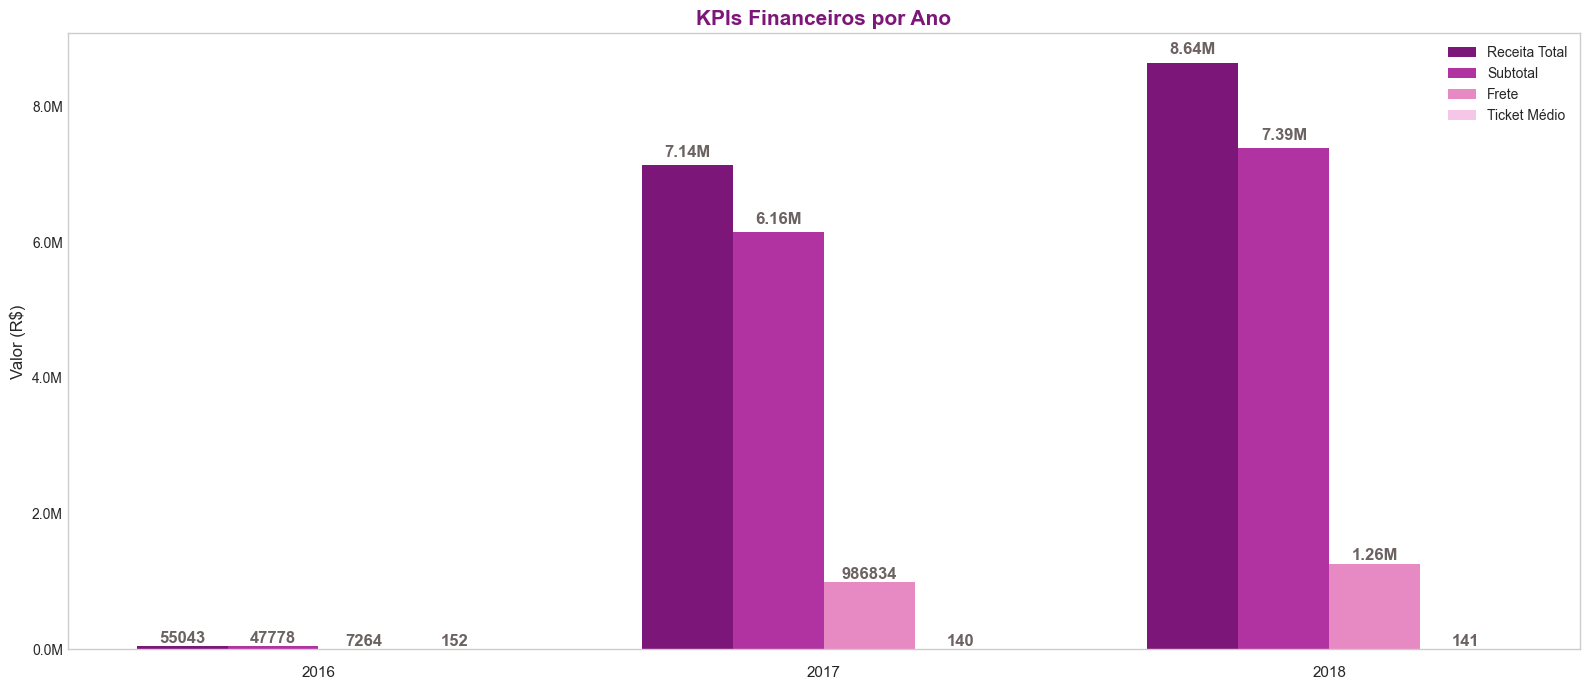

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

cores = ["#7c1678", "#b033a1", "#e78ac3", "#f5c6e8"]

kpis = ["receita_total", "subtotal", "frete", "ticket_medio"]
labels = ["Receita Total", "Subtotal", "Frete", "Ticket Médio"]

anos = kpi_year["order_year"].values
x = np.arange(len(anos))
largura = 0.18

plt.figure(figsize=(16, 7))

ax = plt.gca()
ax.grid(False)

def milhões(x, pos):
    return f"{x/1_000_000:.1f}M"

ax.yaxis.set_major_formatter(mtick.FuncFormatter(milhões))


for i, kpi in enumerate(kpis):
    valores = kpi_year[kpi]
    bars = plt.bar(
        x + i * largura,
        valores,
        width=largura,
        label=labels[i],
        color=cores[i]
    )
    
    for bar in bars:
        altura = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            altura + (altura * 0.01),   
            f"{altura/1_000_000:.2f}M" if altura > 1_000_000 else f"{altura:.0f}",
            ha='center',
            va='bottom',
            fontsize=12,
            color='#6c6262',
            fontweight='bold'
        )

plt.xticks(x + largura * 1.5, anos, fontsize=11)
plt.gca().tick_params(axis="x", pad=12)

plt.ylabel("Valor (R$)", fontsize=12)
plt.title("KPIs Financeiros por Ano", fontsize=15, fontweight="bold", color="#7c1678")
plt.legend()
plt.tight_layout()

plt.savefig('./outputs/04_kpis_insights/kpisFinanceiroAno.png', dpi=300, bbox_inches='tight')
plt.show()

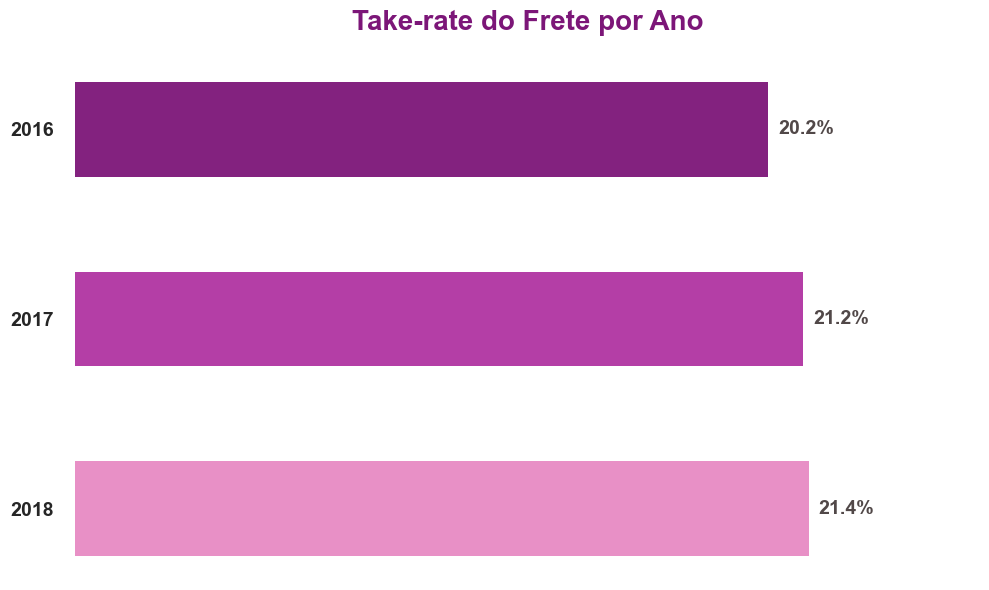

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Dados (ordenados corretamente em 2016 → 2018)
anos = ["2016", "2017", "2018"]
valores = [20.23, 21.25, 21.42]
cores = ["#7c1678", "#b033a1", "#e78ac3"]

# Reverte para que o barh exiba de cima para baixo: 2016, 2017, 2018
anos = anos[::-1]
valores = valores[::-1]
cores = cores[::-1]

plt.figure(figsize=(10, 6))
ax = plt.gca()

y = np.arange(len(anos))

bars = ax.barh(
    y,
    valores,
    color=cores,
    alpha=0.95,
    height=0.5
)

# Rótulos dos valores
for bar, valor in zip(bars, valores):
    ax.text(
        bar.get_width() + 0.3,
        bar.get_y() + bar.get_height() / 2,
        f"{valor:.1f}%",
        ha='left',
        va='center',
        fontsize=14,
        color="#514848",
        fontweight='bold'
    )

# Rótulos dos anos (AFASADOS)
ax.set_yticks(y)
ax.set_yticklabels(anos, fontsize=14, fontweight='bold')
ax.tick_params(axis="y", pad=15)   # <<–– AFASTA OS ANOS DAS BARRAS

# Remove eixo X e bordas
ax.xaxis.set_visible(False)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlim(0, max(valores) + 5)

plt.title(
    "Take-rate do Frete por Ano",
    fontsize=20,
    fontweight="bold",
    color="#7c1678",
    pad=20
)

plt.tight_layout()
plt.savefig('./outputs/04_kpis_insights/takeRateFreteAno.png', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
frete_medio_ano = (
    df_orders
        .groupby('order_year')
        .agg(frete_medio=('freight', 'mean'))
        .reset_index()
)
frete_medio_ano


,order_year,frete_medio
0,2016,23.740163
1,2017,22.137739
2,2018,23.387202


In [21]:
kpi_year = kpi_year.sort_values("order_year")

kpi_year['var_receita_%'] = kpi_year['receita_total'].pct_change() * 100
kpi_year['var_frete_%'] = kpi_year['frete'].pct_change() * 100

kpi_year


,order_year,receita_total,subtotal,frete,ticket_medio,take_rate_frete,lead_time,atraso_pct,cancel_pct,n_pedidos,n_clientes,var_receita_%,var_frete_%
0,2016,55042.72,47778.23,7264.49,151.632837,20.624349,19.343653,1.377410,4.132231,306,306,NaN,NaN
1,2017,7142431.35,6155597.38,986833.97,140.430415,21.245294,12.456209,5.402961,0.485637,44577,44577,12876.159881,13484.353065
2,2018,8643697.60,7386050.80,1257646.80,140.740159,21.416665,11.599993,7.346620,0.455907,53775,53775,21.018980,27.442593


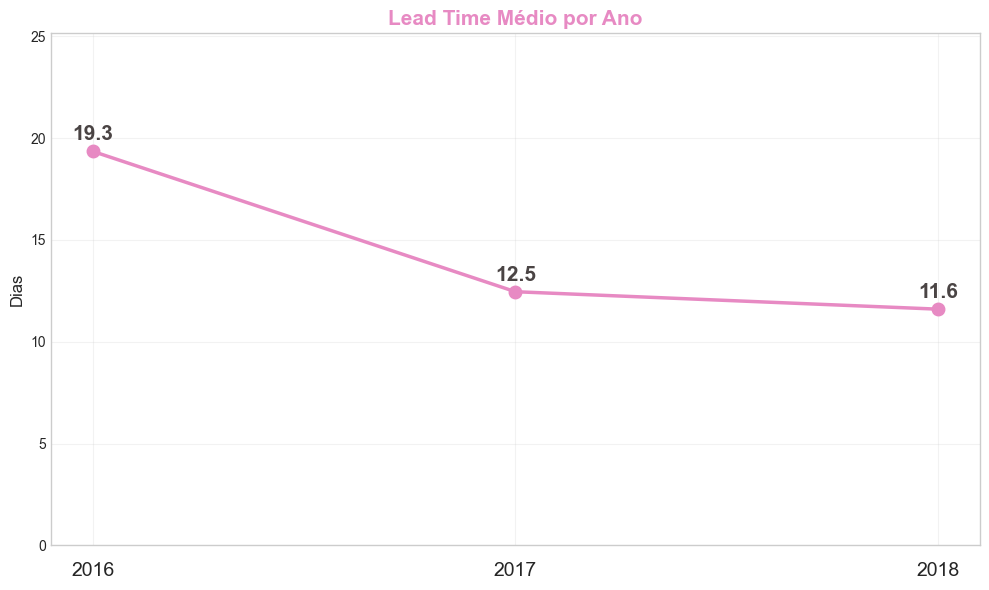

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

anos = kpi_year["order_year"].values   # [2016, 2017, 2018]
x = np.arange(len(anos))
lead = kpi_year["lead_time"].values

plt.figure(figsize=(10, 6))
ax1 = plt.gca()

ax1.plot(x, lead, marker="o", color=cores[0], linewidth=2.5, markersize=9)

y_max = lead.max()
ax1.set_ylim(0, y_max * 1.3)

for xi, yi in zip(x, lead):
    ax1.annotate(
        f"{yi:.1f}",
        (xi, yi),
        textcoords="offset points",
        xytext=(0, 8),      
        ha='center',
        fontsize=15,
        fontweight='bold',
        color="#4a4444"
    )

ax1.set_title("Lead Time Médio por Ano", fontsize=15, fontweight="bold", color=cores[0])
ax1.set_ylabel("Dias", fontsize=12)


ax1.set_xticks(x)
ax1.set_xticklabels(anos, fontsize=14)
ax1.tick_params(axis="x", pad=12)   
ax1.set_xlabel("")                 

ax1.grid(alpha=0.25)

plt.tight_layout()
plt.savefig('./outputs/04_kpis_insights/kpi_leadtime_ano.png',
            dpi=300, bbox_inches='tight')
plt.show()


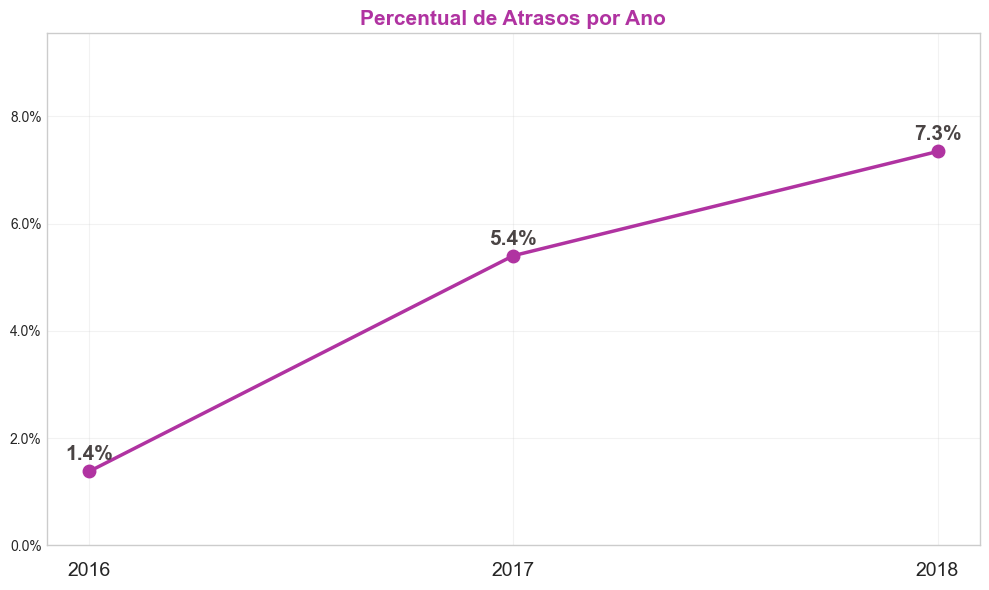

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

anos = kpi_year["order_year"].values
x = np.arange(len(anos))
atraso = kpi_year["atraso_pct"].values   # já em %

plt.figure(figsize=(10, 6))
ax2 = plt.gca()

ax2.plot(x, atraso, marker="o", color=cores[1], linewidth=2.5, markersize=9)

y_max = atraso.max()
ax2.set_ylim(0, y_max * 1.3)

for xi, yi in zip(x, atraso):
    ax2.annotate(
        f"{yi:.1f}%",
        (xi, yi),
        textcoords="offset points",
        xytext=(0, 8),
        ha='center',
        fontsize=15,
        fontweight='bold',
        color="#4a4444"
    )

ax2.set_title("Percentual de Atrasos por Ano", fontsize=15, fontweight="bold", color=cores[1])

ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_xticks(x)
ax2.set_xticklabels(anos, fontsize=14)
ax2.tick_params(axis="x", pad=12)
ax2.set_xlabel("")
ax2.grid(alpha=0.25)

plt.tight_layout()
plt.savefig('./outputs/04_kpis_insights/kpi_atrasos_ano.png',
            dpi=300, bbox_inches='tight')
plt.show()


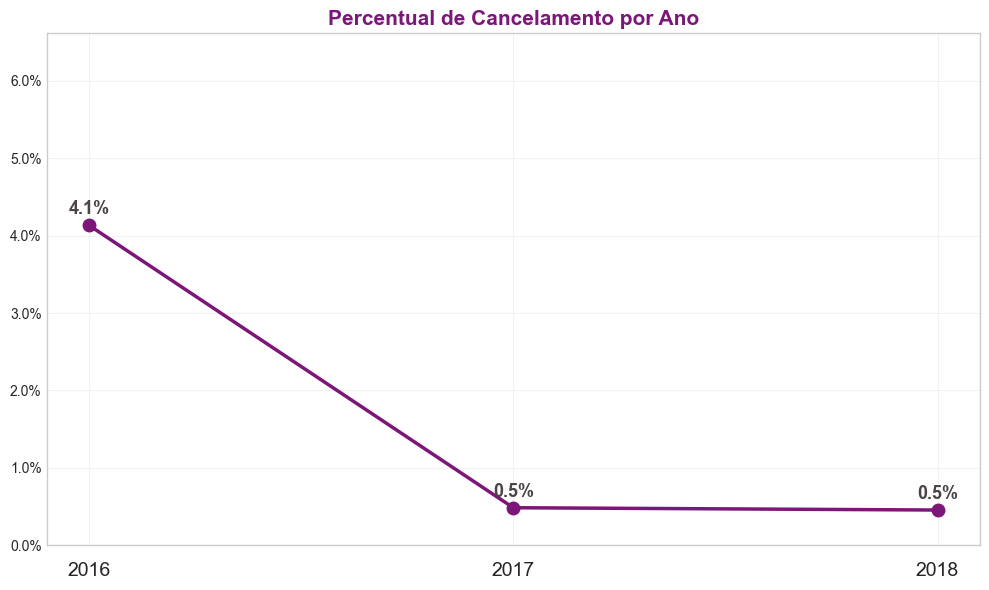

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

anos = kpi_year["order_year"].values
x = np.arange(len(anos))
cancel = kpi_year["cancel_pct"].values   # já em %

plt.figure(figsize=(10, 6))
ax3 = plt.gca()

ax3.plot(x, cancel, marker="o", color=cores[2], linewidth=2.5, markersize=9)

y_max = cancel.max()
ax3.set_ylim(0, y_max * 1.6)   

for xi, yi in zip(x, cancel):
    ax3.annotate(
        f"{yi:.1f}%",
        (xi, yi),
        textcoords="offset points",
        xytext=(0, 8),    
        ha='center',
        fontsize=13,
        fontweight='bold',
        color="#4a4444"
    )

ax3.set_title("Percentual de Cancelamento por Ano", fontsize=15, fontweight="bold", color=cores[2])
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.set_xticks(x)
ax3.set_xticklabels(anos, fontsize=14)
ax3.tick_params(axis="x", pad=12)
ax3.set_xlabel("")
ax3.grid(alpha=0.25)

plt.tight_layout()
plt.savefig('./outputs/04_kpis_insights/kpi_cancelamento_ano.png',
            dpi=300, bbox_inches='tight')
plt.show()


In [25]:
payment_conversion = df.groupby('payment_type').agg(
    taxa_confirmado=('is_confirmed', 'mean'),
    taxa_cancelado=('is_canceled', 'mean'),
    pedidos=('order_id', 'nunique')
).reset_index()

payment_conversion['taxa_confirmado'] *= 100
payment_conversion['taxa_cancelado'] *= 100

payment_conversion


,payment_type,taxa_confirmado,taxa_cancelado,pedidos
0,boleto,97.791577,0.419819,19614
1,credit_card,97.845524,0.503447,75615
2,debit_card,97.809355,0.355240,1520
3,voucher,97.685632,0.337512,1908


In [26]:
df['order_year'] = df['order_purchase_timestamp'].dt.year


In [27]:
payment_conversion_year = (
    df.groupby(['order_year', 'payment_type'])
      .agg(
          taxa_confirmado=('is_confirmed', 'mean'),
          taxa_cancelado=('is_canceled', 'mean'),
          pedidos=('order_id', 'nunique')
      )
      .reset_index()
)

payment_conversion_year['taxa_confirmado'] *= 100
payment_conversion_year['taxa_cancelado'] *= 100

payment_conversion_year


,order_year,payment_type,taxa_confirmado,taxa_cancelado,pedidos
0,2016,boleto,85.915493,0.000000,58
1,2016,credit_card,87.544484,5.338078,239
2,2016,debit_card,100.000000,0.000000,2
3,2016,voucher,83.333333,0.000000,6
4,2017,boleto,97.236204,0.475885,9381
5,2017,credit_card,97.501430,0.491394,33834
6,2017,debit_card,97.204301,0.645161,419
7,2017,voucher,97.120159,0.297915,943
8,2018,boleto,98.373915,0.370714,10175
9,2018,credit_card,98.186781,0.484513,41542


In [28]:
wide_confirmado = (
    payment_conversion_year
        .pivot_table(
            index='order_year',
            columns='payment_type',
            values='taxa_confirmado'
        )
        .reset_index()
)

wide_confirmado


payment_type,order_year,boleto,credit_card,debit_card,voucher
0,2016,85.915493,87.544484,100.000000,83.333333
1,2017,97.236204,97.501430,97.204301,97.120159
2,2018,98.373915,98.186781,98.036007,98.303487


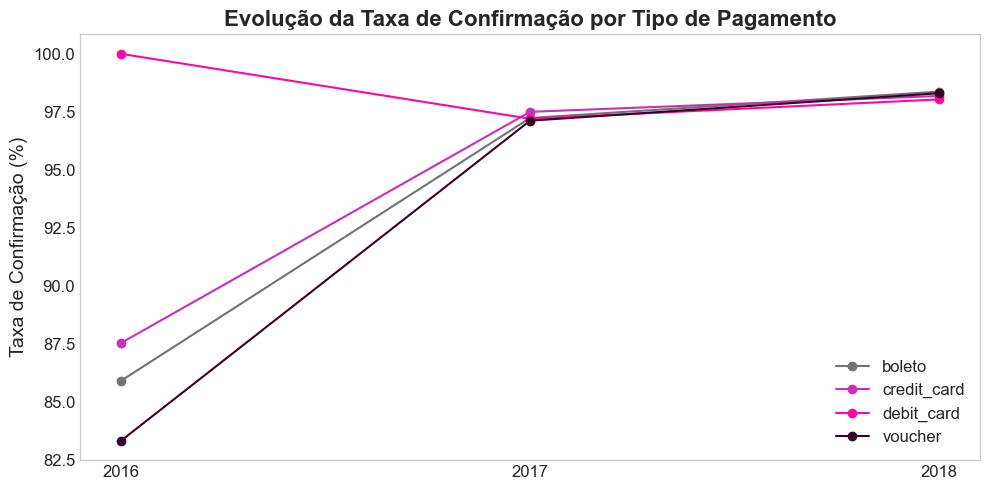

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

cores = ["#737373", "#cb2eb9", "#ff0aa1", "#370028"]

for col, cor in zip(wide_confirmado.columns[1:], cores):
    ax.plot(wide_confirmado['order_year'], wide_confirmado[col], marker='o', label=col, color=cor)



ax.set_xlabel("")
ax.set_ylabel("Taxa de Confirmação (%)", fontsize=14)
ax.set_title("Evolução da Taxa de Confirmação por Tipo de Pagamento", fontsize=16, fontweight="bold")
ax.legend()
plt.grid(False)
plt.xticks([2016, 2017, 2018])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('./outputs/04_kpis_insights/taxaconfirmada_pagamento.png',
            dpi=300, bbox_inches='tight')

plt.show()


In [30]:
wide_cancelado = (
    payment_conversion_year
        .pivot_table(
            index='order_year',
            columns='payment_type',
            values='taxa_cancelado'
        )
        .reset_index()
)

wide_cancelado


payment_type,order_year,boleto,credit_card,debit_card,voucher
0,2016,0.000000,5.338078,0.000000,0.000000
1,2017,0.475885,0.491394,0.645161,0.297915
2,2018,0.370714,0.484513,0.245499,0.377003


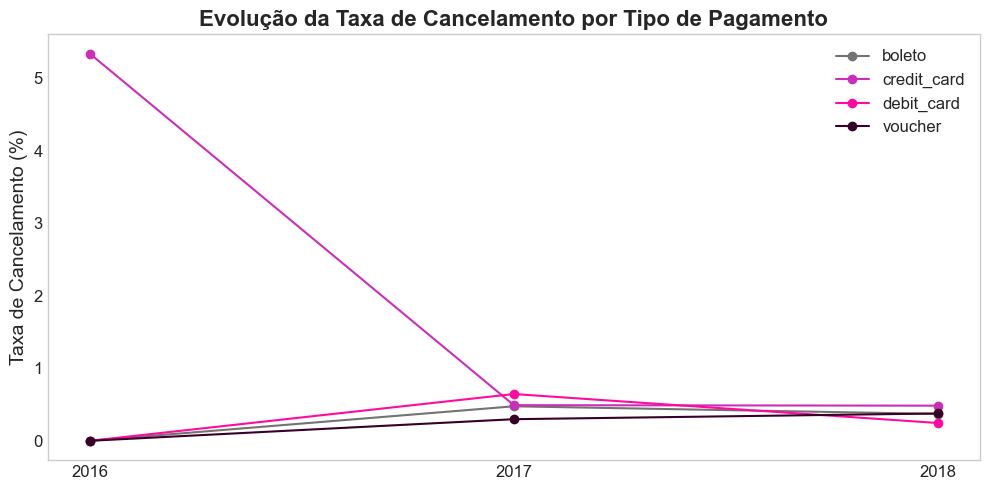

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

cores = ["#737373", "#cb2eb9", "#ff0aa1", "#370028"]

for col, cor in zip(wide_cancelado.columns[1:], cores):
    ax.plot(
        wide_cancelado['order_year'],
        wide_cancelado[col],
        marker='o',
        label=col,
        color=cor
    )

ax.set_xlabel("")
ax.set_ylabel("Taxa de Cancelamento (%)", fontsize=14)
ax.set_title(
    "Evolução da Taxa de Cancelamento por Tipo de Pagamento",
    fontsize=16,
    fontweight="bold"
)

plt.xticks([2016, 2017, 2018], fontsize=12)

plt.yticks(fontsize=12)

plt.legend(fontsize=12)
plt.grid(False)

plt.tight_layout()
plt.savefig('./outputs/04_kpis_insights/taxacancelada_pagamento.png',
            dpi=300, bbox_inches='tight')
plt.show()


In [32]:
wide_pedidos = (
    payment_conversion_year
        .pivot_table(
            index='order_year',
            columns='payment_type',
            values='pedidos'
        )
        .reset_index()
)

wide_pedidos


payment_type,order_year,boleto,credit_card,debit_card,voucher
0,2016,58.0,239.0,2.0,6.0
1,2017,9381.0,33834.0,419.0,943.0
2,2018,10175.0,41542.0,1099.0,959.0


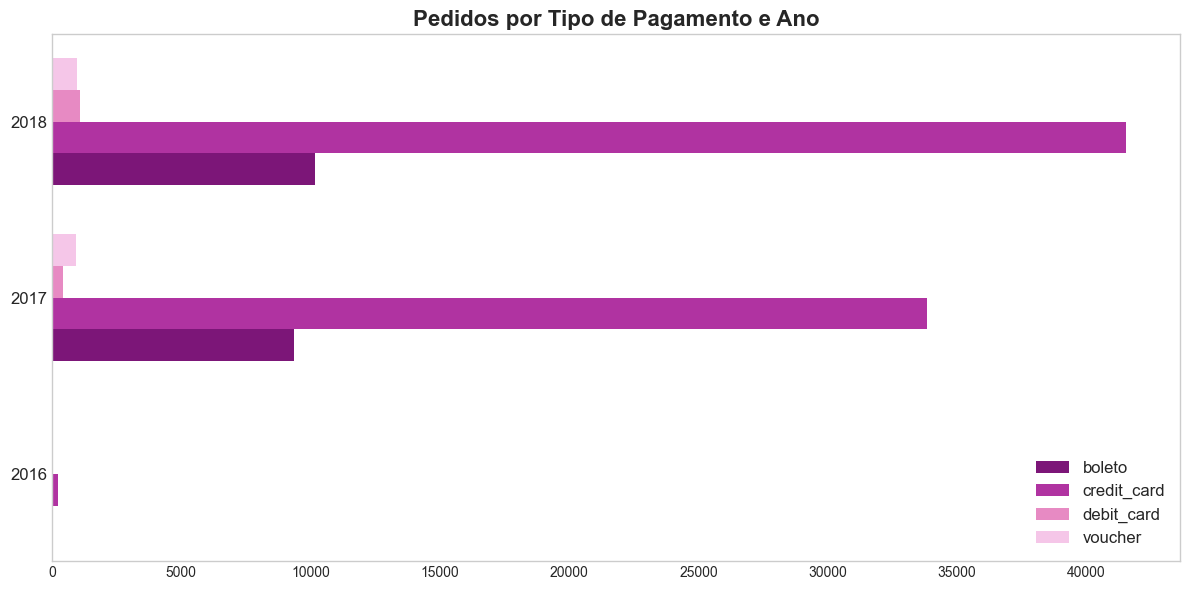

In [47]:
import matplotlib.pyplot as plt
import numpy as np


cores = ["#7c1678", "#b033a1", "#e78ac3", "#f5c6e8"]

anos = wide_pedidos["order_year"]
payment_types = wide_pedidos.columns[1:]  

y = np.arange(len(anos))
altura = 0.18   

fig, ax = plt.subplots(figsize=(12, 6))

for i, (col, cor) in enumerate(zip(payment_types, cores)):
    ax.barh(
        y + i*altura,
        wide_pedidos[col],
        height=altura,
        label=col,
        color=cor
    )

ax.set_yticks(y + altura*1.5)
ax.set_yticklabels(anos, fontsize=12)

ax.set_xlabel("", fontsize=14)
ax.set_title("Pedidos por Tipo de Pagamento e Ano", fontsize=16, fontweight="bold")
ax.legend(fontsize=12, loc='lower right')
plt.grid(False)
plt.tight_layout()
plt.savefig('./outputs/04_kpis_insights/pedidos_pagamento_ano.png',
            dpi=300, bbox_inches='tight')
plt.show()


In [34]:
mix_categoria = df.groupby('product_category_name_english').agg(
    receita=('total', 'sum'),
    pedidos=('order_id', 'nunique')
).reset_index().sort_values(by='receita', ascending=False)

mix_categoria


,product_category_name_english,receita,pedidos
43,health_beauty,1441248.07,8836
70,watches_gifts,1305541.61,5624
7,bed_bath_table,1241681.72,9417
65,sports_leisure,1156656.48,7720
15,computers_accessories,1059210.78,6688
...,...,...,...
35,flowers,1598.91,29
46,home_comfort_2,1170.58,24
11,cds_dvds_musicals,954.99,12
29,fashion_childrens_clothes,665.36,8


In [35]:
mix_categoria.head(5)

,product_category_name_english,receita,pedidos
43,health_beauty,1441248.07,8836
70,watches_gifts,1305541.61,5624
7,bed_bath_table,1241681.72,9417
65,sports_leisure,1156656.48,7720
15,computers_accessories,1059210.78,6688


In [36]:
sazonalidade_uf = df.groupby(['order_year', 'customer_state']).agg(
    pedidos=('order_id', 'nunique'),
    receita=('total', 'sum')
).reset_index()


In [37]:
sazonalidade_regiao = df.groupby(['order_year', 'customer_region']).agg(
    pedidos=('order_id', 'nunique'),
    receita=('total', 'sum')
).reset_index()


sazoniladade - para gráfico/slide

In [38]:
# KPI 1 — Sazonalidade Mensal
monthly_kpis = (
    df_orders
        .groupby('order_month')
        .agg({
            'order_id': 'count',
            'total': 'sum',
            'freight': 'mean',
            'delivery_lead_time': 'mean'
        })
        .reset_index()
)

monthly_kpis.columns = ['month', 'n_orders', 'revenue', 'avg_freight', 'avg_delivery_time']

monthly_kpis


,month,n_orders,revenue,avg_freight,avg_delivery_time
0,2016-09-01,3,354.75,29.130000,54.000000
1,2016-10-01,302,54668.35,23.736358,19.111111
2,2016-12-01,1,19.62,8.720000,4.000000
3,2017-01-01,789,137188.49,21.388619,12.092000
4,2017-02-01,1732,286219.00,22.491732,12.606171
5,2017-03-01,2641,432048.59,21.849409,12.395522
6,2017-04-01,2390,412242.78,21.960439,14.352584
7,2017-05-01,3660,586190.95,21.890658,10.760508
8,2017-06-01,3217,502963.04,21.735915,11.506220
9,2017-07-01,3969,584971.62,21.904797,11.131198


In [39]:
# KPI 2 — Sazonalidade por Estado
state_kpis = (
    df_orders
        .groupby('customer_state')
        .agg({
            'order_id': 'count',
            'total': 'sum'
        })
        .reset_index()
)

state_kpis.columns = ['state', 'n_orders', 'revenue']
state_kpis = state_kpis.sort_values('revenue', ascending=False).head(5)

state_kpis


,state,n_orders,revenue
25,SP,41371,5920134.69
18,RJ,12761,2129368.40
10,MG,11542,1855907.68
22,RS,5431,885556.01
17,PR,4998,800935.44


In [40]:
# KPI 3 — Sazonalidade por Região
region_kpis = (
    df_orders
        .groupby('customer_region')
        .agg({
            'order_id': 'count',
            'total': ['sum', 'mean'],
            'freight': 'mean',
            'delivery_lead_time': 'mean',
            'is_late': 'mean'
        })
        .reset_index()
)

region_kpis.columns = [
    'region', 'n_orders', 'revenue', 'avg_ticket',
    'avg_freight', 'avg_delivery_time', 'late_rate'
]

region_kpis['late_rate'] *= 100
region_kpis = region_kpis.sort_values('revenue', ascending=False)

region_kpis


,region,n_orders,revenue,avg_ticket,avg_freight,avg_delivery_time,late_rate
3,Sudeste,67699,10230212.68,151.113202,19.864208,10.289269,5.980886
4,Sul,14041,2296705.05,163.571330,24.429444,13.558636,5.804430
1,Nordeste,9336,1880799.54,201.456677,35.915359,19.536046,12.317909
0,Centro-Oeste,5744,1023062.00,178.109680,26.566842,14.563656,6.389276
2,Norte,1838,410392.40,223.282046,41.370343,22.144209,8.378672


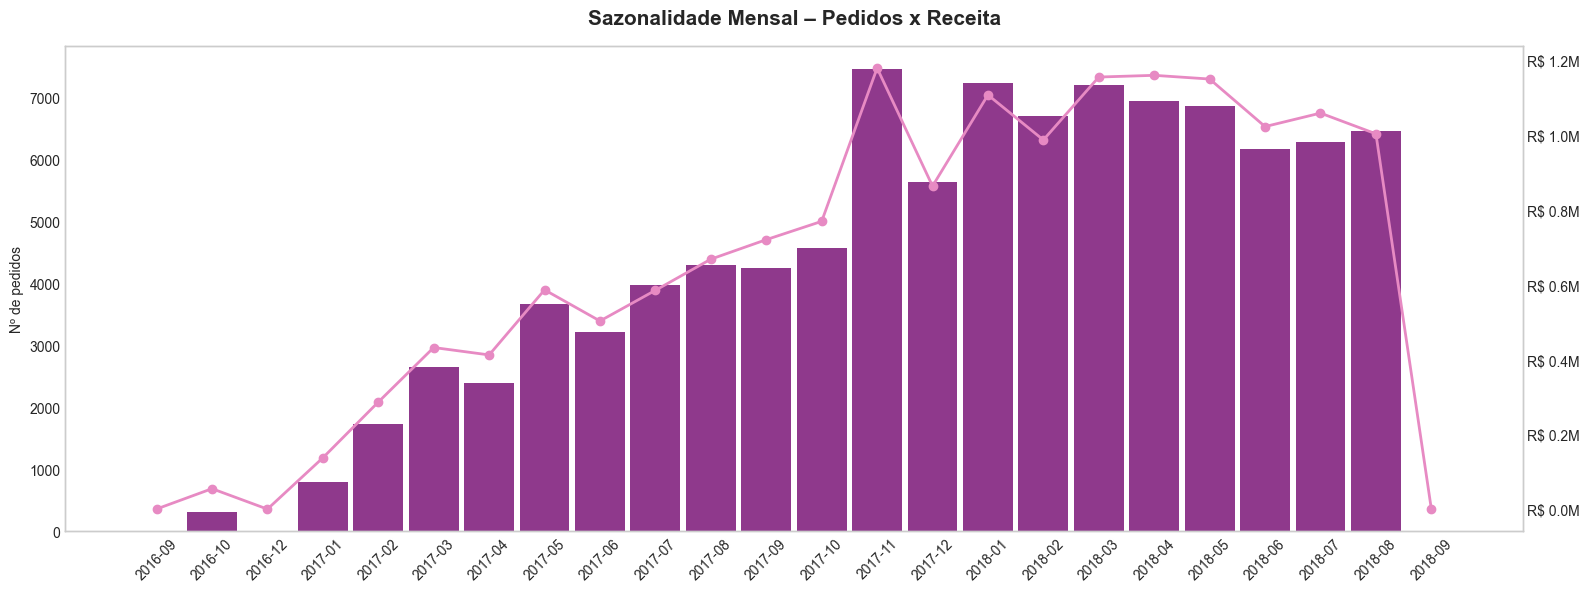

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

fig, ax1 = plt.subplots(figsize=(16, 6))

x = np.arange(len(monthly_kpis))
labels = monthly_kpis['month'].dt.strftime('%Y-%m')

ax1.bar(
    x,
    monthly_kpis['n_orders'],
    width=0.9,
    color="#7c1678",
    alpha=0.85,
    label="Nº Pedidos"
)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)
ax1.set_ylabel("Nº de pedidos")

plt.grid(False)

ax2 = ax1.twinx()
ax2.plot(x, monthly_kpis['revenue'], marker="o", color="#e78ac3", linewidth=2, label="Receita")

ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"R$ {x/1_000_000:.1f}M"))
plt.grid(False)
fig.suptitle("Sazonalidade Mensal – Pedidos x Receita", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.savefig('./outputs/04_kpis_insights/sazonalidade_mensal.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
df_orders[
    (df_orders['order_purchase_timestamp'].dt.year == 2016) &
    (df_orders['order_purchase_timestamp'].dt.month == 12)
]


,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_value,payment_installments,customer_state,...,subtotal,delivery_lead_time,delivery_delay_days,is_late,is_confirmed,is_canceled,order_month,order_year,discount_amount,discount_pct
72905,bd50a7fe9fd97ea4b7663031a319e150,0975c3cf2e418ebfa5d1191a2dffd59d,delivered,2016-12-23 23:16:47,2016-12-28 15:54:44,2017-01-19,credit_card,19.62,1.0,PR,...,10.9,4.0,-22.0,0,1,0,2016-12-01,2016,0.0,0.0


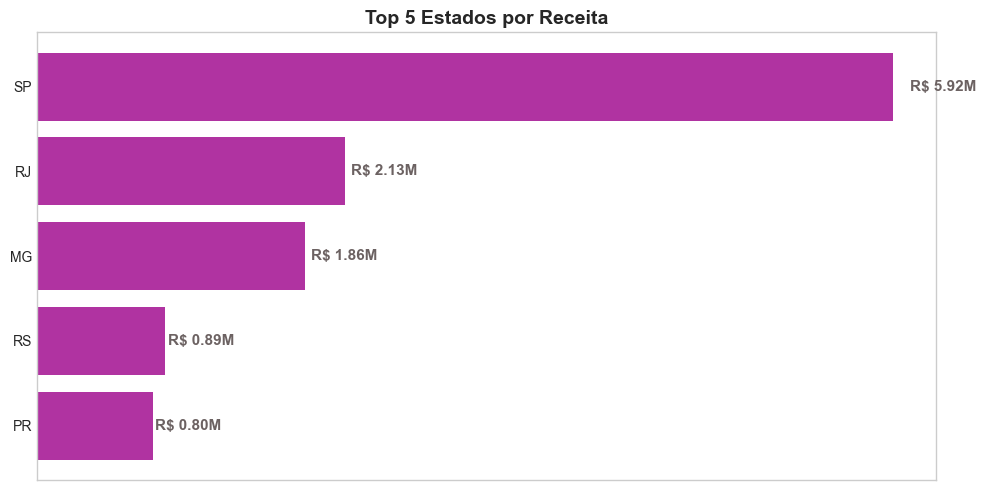

In [43]:
fig, ax = plt.subplots(figsize=(10,5))

state_kpis_sorted = state_kpis.sort_values("revenue", ascending=True)

ax.barh(
    state_kpis_sorted["state"],
    state_kpis_sorted["revenue"],
    color="#b033a1"
)

for value, label in zip(state_kpis_sorted["revenue"], state_kpis_sorted["state"]):
    ax.text(
        value + value*0.02,         
        label,
        f"R$ {value/1_000_000:.2f}M",
        va='center',
        ha='left',
        fontsize=11,
        color="#6c6262",
        fontweight="bold"
    )

ax.xaxis.set_visible(False)

plt.title("Top 5 Estados por Receita", fontsize=14, fontweight="bold")
plt.xlabel("")
plt.grid(False)
plt.tight_layout()

plt.savefig('./outputs/04_kpis_insights/top5_estados_receita.png', dpi=300, bbox_inches='tight')
plt.show()

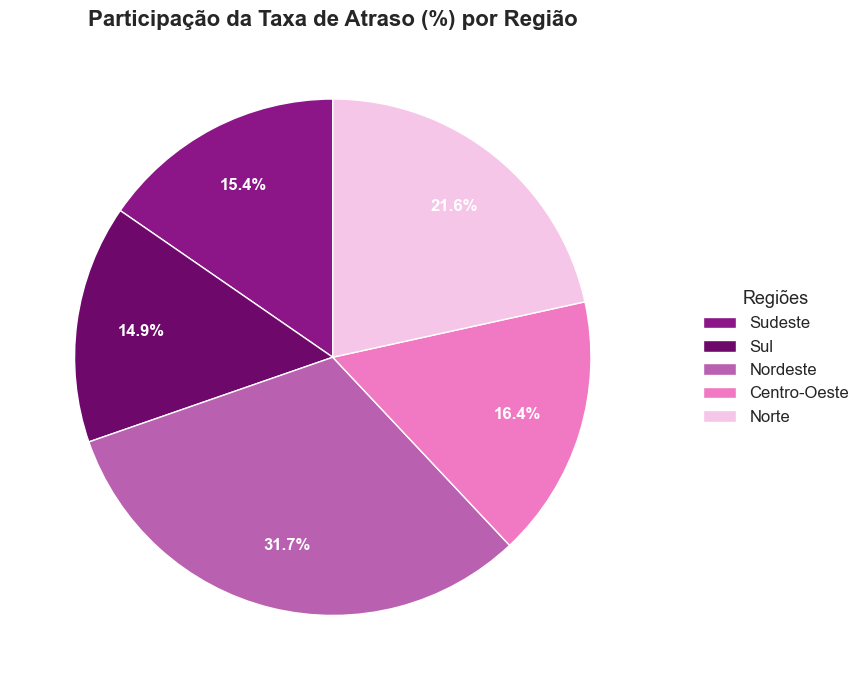

In [44]:
import matplotlib.pyplot as plt


atrasos = region_kpis['late_rate']
labels = region_kpis['region']


cores = ["#8C1588", "#6e096b", "#ba60b0", "#f179c3", "#f5c6e8"]

fig, ax = plt.subplots(figsize=(10, 7))

wedges, texts, autotexts = ax.pie(
    atrasos,
    labels=None,                
    colors=cores,
    autopct=lambda p: f'{p:.1f}%',   
    pctdistance=0.75,        
    startangle=90,
    textprops={'fontsize': 12, 'color': 'white', 'fontweight': 'bold'}
)


for w in wedges:
    w.set_edgecolor('white')
    w.set_linewidth(1)

plt.legend(
    wedges,
    labels,
    title="Regiões",
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    fontsize=12,
    title_fontsize=13
)

ax.set_title(
    "Participação da Taxa de Atraso (%) por Região",
    fontsize=16,
    fontweight="bold"
)

plt.tight_layout()
plt.savefig('./outputs/04_kpis_insights/taxa_atraso_regiao.png'),
plt.show()

